In [1]:
!pip install sacrebleu rouge-score --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.4 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import MarianMTModel, MarianTokenizer
from datasets import Dataset
import pandas as pd
import html
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from tqdm import tqdm
from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer

2025-05-02 09:54:26.330243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746179666.498807      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746179666.552868      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Load and split data
def load_and_split_data(en_path, vi_path, seed=42):
    def clean_entities(text):
        return html.unescape(text.strip())  # vừa strip vừa giải mã entity
        
    with open(en_path, 'r', encoding='utf-8') as f_en, open(vi_path, 'r', encoding='utf-8') as f_vi:
        en_lines = [clean_entities(line) for line in f_en]
        vi_lines = [clean_entities(line) for line in f_vi]
    if len(en_lines) != len(vi_lines):
        raise ValueError(f"Số dòng không khớp: {len(en_lines)} EN vs {len(vi_lines)} VI")

    df = pd.DataFrame({'en': en_lines, 'vi': vi_lines})
    df_train, df_temp = train_test_split(df, test_size=0.2, random_state=seed)
    df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=seed)
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

In [6]:
en_path ="/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/train.en.txt"
vi_path ="/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/train.vi.txt"

In [7]:
print("Loading & splitting data...")
df_train, df_val, df_test = load_and_split_data(en_path, vi_path)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

Loading & splitting data...
(106653, 2)
(13332, 2)
(13332, 2)


In [8]:
# Preprocess data
def preprocess_data(df, tokenizer):
    from datasets import Dataset

    dataset = Dataset.from_pandas(df.dropna().reset_index(drop=True).astype(str))

    def preprocess(batch):
        en_sentences = batch["en"]
        vi_sentences = batch["vi"]

        inputs = tokenizer(en_sentences, max_length=128, truncation=True, padding="max_length")
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(vi_sentences, max_length=128, truncation=True, padding="max_length")

        return {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "labels": labels["input_ids"]
        }

    return dataset.map(preprocess, batched=True)

In [9]:
# Collate function
def collate_fn(batch):
    return {
        "input_ids": torch.tensor([b['input_ids'] for b in batch], dtype=torch.long),
        "attention_mask": torch.tensor([b['attention_mask'] for b in batch], dtype=torch.long),
        "labels": torch.tensor([b['labels'] for b in batch], dtype=torch.long)
    }

In [10]:
# Translate function
def translate(text, model, tokenizer):
    model.eval()
    device = next(model.parameters()).device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model.generate(**inputs, max_length=128)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [11]:
from tqdm import tqdm
from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer

def evaluate(df_test, model, tokenizer, num_samples=None):
    refs, preds = [], []
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge1_scores, rougeL_scores = [], []

    range_len = range(len(df_test)) if num_samples is None else range(min(num_samples, len(df_test)))
    
    print(f"Đang đánh giá {len(range_len)} câu...")
    for i in tqdm(range_len, desc="Evaluating"):
        src = df_test['en'][i]
        ref = df_test['vi'][i]
        pred = translate(src, model, tokenizer)

        refs.append([ref])
        preds.append(pred)

        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    bleu = corpus_bleu(preds, refs)
    print(f"\n BLEU score: {bleu.score:.2f}")
    print(f" ROUGE-1 F1: {sum(rouge1_scores)/len(rouge1_scores):.4f}")
    print(f" ROUGE-L F1: {sum(rougeL_scores)/len(rougeL_scores):.4f}")


In [12]:
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import torch
val_losses = []
train_losses = []
def train_with_validation(df_train, df_val, tokenizer, model, df_test, batch_size=16, num_epochs=10, lr=2e-5, patience=2):

    global train_losses, val_losses
    train_losses = []
    val_losses = []
    # Khởi tạo dataset và DataLoader
    train_dataset = preprocess_data(df_train, tokenizer)
    val_dataset = preprocess_data(df_val, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Khởi tạo optimizer và scaler cho mixed precision
    optimizer = AdamW(model.parameters(), lr=lr)
    scaler = GradScaler()  # Scaler cho AMP
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    counter = 0

    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        print(f"\n Epoch {epoch+1}/{num_epochs}")
        for batch in tqdm(train_loader, desc="Training"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Sử dụng autocast để tự động chọn độ chính xác (FP16/FP32)
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            # Backward pass với scaler để điều chỉnh gradient
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        print(f" Train loss: {avg_train_loss:.4f}")
        train_losses.append(avg_train_loss)
        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                batch = {k: v.to(device) for k, v in batch.items()}
                # Sử dụng autocast trong validation để tăng tốc
                with autocast():
                    loss = model(**batch).loss
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        print(f" Val loss: {avg_val_loss:.4f}")
        val_losses.append(avg_val_loss)
        # # Đánh giá BLEU và ROUGE trên 30 mẫu test
        # evaluate(df_test, model, tokenizer, num_samples=30)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            print(" Saving best model...")
            model.save_pretrained("./opus-en-vi-best")
            tokenizer.save_pretrained("./opus-en-vi-best")
        else:
            counter += 1
            if counter >= patience:
                print(" Early stopping triggered!")
                break

    return model

In [13]:
print("Loading model & tokenizer...")
model_name = "Helsinki-NLP/opus-mt-en-vi"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

Loading model & tokenizer...


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/756k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/289M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/289M [00:00<?, ?B/s]

In [ ]:
# print(f"[DEBUG] type(tokenizer): {type(tokenizer)}")

In [14]:
# Train model
print("Training with early stopping...")
model = train_with_validation(df_train, df_val, tokenizer, model, df_test)

Training with early stopping...


Map:   0%|          | 0/106653 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/13332 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/tmp/ipykernel_31/640409350.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Scaler cho AMP



 Epoch 1/10


Training:   0%|          | 0/6666 [00:00<?, ?it/s]/tmp/ipykernel_31/640409350.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 6666/6666 [16:58<00:00,  6.55it/s]


 Train loss: 0.3257


Validating:   0%|          | 0/834 [00:00<?, ?it/s]/tmp/ipykernel_31/640409350.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating: 100%|██████████| 834/834 [00:43<00:00, 19.22it/s]
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[53684]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


 Val loss: 0.2885
 Saving best model...

 Epoch 2/10


Training:   0%|          | 0/6666 [00:00<?, ?it/s]/tmp/ipykernel_31/640409350.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 6666/6666 [17:03<00:00,  6.51it/s]


 Train loss: 0.2887


Validating:   0%|          | 0/834 [00:00<?, ?it/s]/tmp/ipykernel_31/640409350.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating: 100%|██████████| 834/834 [00:43<00:00, 19.23it/s]


 Val loss: 0.2864
 Saving best model...

 Epoch 3/10


Training:   0%|          | 0/6666 [00:00<?, ?it/s]/tmp/ipykernel_31/640409350.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 6666/6666 [17:07<00:00,  6.49it/s]


 Train loss: 0.2707


Validating:   0%|          | 0/834 [00:00<?, ?it/s]/tmp/ipykernel_31/640409350.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating: 100%|██████████| 834/834 [00:43<00:00, 19.24it/s]


 Val loss: 0.2873

 Epoch 4/10


Training: 100%|██████████| 6666/6666 [17:05<00:00,  6.50it/s]


 Train loss: 0.2558


Validating: 100%|██████████| 834/834 [00:43<00:00, 19.14it/s]


 Val loss: 0.2882
 Early stopping triggered!


In [15]:
from transformers import MarianMTModel, MarianTokenizer

# Đường dẫn đến thư mục chứa mô hình đã lưu
model_path = "./opus-en-vi-best"

# Load mô hình và tokenizer
model = MarianMTModel.from_pretrained(model_path)
tokenizer = MarianTokenizer.from_pretrained(model_path)

# Chuyển mô hình sang device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # Chuyển sang chế độ đánh giá (inference)

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(53685, 512, padding_idx=53684)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(53685, 512, padding_idx=53684)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

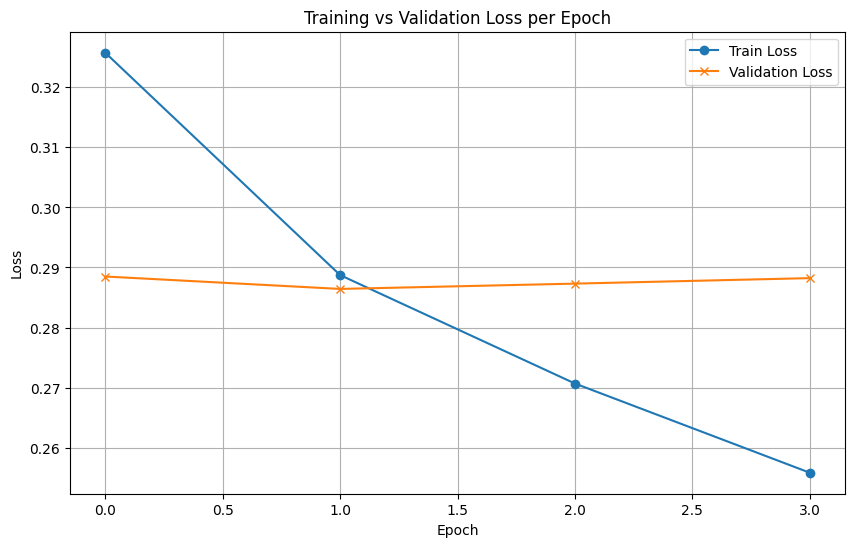

In [16]:
#chạy lại ko đc đụng-_-

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title("Training vs Validation Loss per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')

In [18]:
print("Đánh giá mô hình trên toàn bộ tập test...")
evaluate(df_test, model, tokenizer, num_samples=None)

Đánh giá mô hình trên toàn bộ tập test...
Đang đánh giá 13332 câu...


Evaluating: 100%|██████████| 13332/13332 [46:50<00:00,  4.74it/s] 



 BLEU score: 50.17
 ROUGE-1 F1: 0.7421
 ROUGE-L F1: 0.6700


In [20]:
# Lấy 100 câu đầu tiên từ tập test
num_sentences = 100
sample_sentences = df_test['en'].head(num_sentences).tolist()

print("\nDịch thử 100 câu từ tập test:")
for idx, sent in enumerate(sample_sentences):
    # Dịch câu
    translated = translate(sent, model, tokenizer)
    # Lấy câu tham chiếu
    reference = df_test[df_test['en'] == sent]['vi'].iloc[0]
    
    # In kết quả
    print(f"\nCâu {idx+1}:")
    print(f"Tiếng Anh (Input): {sent}")
    print(f"Bản dịch (Predicted): {translated}")
    print(f"Tham chiếu (Reference): {reference}")


Dịch thử 100 câu từ tập test:

Câu 1:
Tiếng Anh (Input): And I would ask him every once in a while , " Dad , do you want it to sound like the record ? "
Bản dịch (Predicted): Và thỉnh thoảng tôi thỉnh thoảng hỏi ông ấy , " Bố , bố có muốn nghe giống như bản thu âm không ? "
Tham chiếu (Reference): Đôi khi , tôi hỏi ông rằng : " Bố ơi , bố có muốn chơi giống như bản gốc không ạ ? "

Câu 2:
Tiếng Anh (Input): So , we 're only going to look at the stars inside that small square , although we 've looked at all of them .
Bản dịch (Predicted): Vì vậy , chúng ta sẽ chỉ nhìn vào các ngôi sao bên trong hình vuông nhỏ đó , mặc dù chúng ta đã quan sát tất cả chúng .
Tham chiếu (Reference): Vậy , chúng ta sẽ chỉ nhìn vào những ngôi sao bên trong hình vuông nhỏ đó , mặt dù chúng ta đã nhìn tất cả chúng .

Câu 3:
Tiếng Anh (Input): And they travel out into the cosmos at the speed of light .
Bản dịch (Predicted): Và chúng đi vào vũ trụ với tốc độ ánh sáng .
Tham chiếu (Reference): Và chúng đi vào vũ